## Predicting Default on Payments of Credit Card Clients

# 3. Model Training & Model Evaluation

The goal of this notebook is to train machine learning models to predict whether a credit card client will default in the following month and evaluate the performance of said models.

### Imports

In [1]:
import sys
sys.path.append("../")

In [38]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, f1_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from modeling.model_trainer import ModelTrainer
from preprocessing.data_loader import download_data_from_kaggle
from preprocessing.data_processor import DataProcessor
from preprocessing.processing_steps import split_dataset

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

### Loading the Data

In [6]:
seed = 1
random_state = np.random.RandomState(seed)

df = download_data_from_kaggle()

X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
splits = split_dataset(
    X=X,
    y=y,
    random_state=random_state,
    shuffle=True,
    stratify=True
)

data_processor = DataProcessor(
    splits=splits,
    data_from_kaggle=True
)
    
# Deal with categorical variables:
data_processor.treat_categorical_variables(drop_original_vars=True)

cat_variables = ["age", "pay_1", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6", "is_male", "is_married", "is_single",
                "graduate_school_education", "university_education", "high_school_education"]
# Note: IQR method was eliminating all negative bill amount statements, and according to the exploratory analysis 
# performed, the negative values contributes to separate defaulters and non-defaulters
bill_variables = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]

# Deal with outliers:
data_processor.treat_outliers(
    column_names=cat_variables + bill_variables,  
    exclude_column_names=True,
    verbose=False
)
    
# Standardize data:
data_processor.standardize_data(
    column_names=[col for col in cat_variables if not col.startswith("pay_")], 
    exclude_column_names=True
)

X_train, y_train, X_val, y_val, X_test, y_test = data_processor.get_datasets()

Training/test split created: 25500 training samples /4500 test samples.
Training/validation split created: 21000 training samples /4500 val samples.


In [7]:
print(f"There are {len(X_train.columns)} variables: {X_train.columns.tolist()}")

There are 26 variables: ['limit_bal', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'is_male', 'is_married', 'is_single', 'graduate_school_education', 'university_education', 'high_school_education']


In [9]:
# Target distribution:
print(round(y_train.sum() / len(y_train), 2))
print(round(y_val.sum() / len(y_val), 2))
print(round(y_test.sum() / len(y_test), 2))

0.22
0.22
0.22


### Modeling - Initial Benchmark

To begin the analysis, a total of 7 different classifiers will be trained, and the best performing models will be selected as baseline models. The chosen classifiers are: AdaBoost (AB), Bagging (B), Support Vector Machine (SVM), Histogram-based Gradient Boosting Tree (HGB), Random Forest (RF), Multi-Layer Perceptron (MLP) and Light Gradient Boosting Machine (LGBM). These classifiers cover a diverse range of algorithms that have been proven to perform well in various machine learning tasks, and in particular with tabular datasets.

In terms of evaluation metrics, given the significance of identifying clients at risk of default and considering the dataset's class imbalance, the primary optimization metric will be the f1-score. Additionally, other metrics will be calculated to provide a comprehensive support for decision-making. 

Regarding the data, at this initial stage the original variables will be used. Categorical variables were encoded using one-hot-encoding and the remaining variables were standardized by using MinMaxScaler. To address outliers, the interquartile range (IQR) method was employed.  

In [10]:
models_trainer = ModelTrainer(X_train, y_train, X_val, y_val, X_test, y_test, seed)

In [11]:
abc = AdaBoostClassifier(random_state=seed)

models_trainer.train_classifier(classifier=abc, classifier_name="AdaBoost")

models_trainer.evaluate_classifier(classifier_name="AdaBoost", store_results=True, print_classification_report=True)

	#### ADABOOST RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16354
           1       0.68      0.34      0.46      4646

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000

Val scores:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3505
           1       0.68      0.35      0.46       995

    accuracy                           0.82      4500
   macro avg       0.76      0.65      0.68      4500
weighted avg       0.80      0.82      0.80      4500



{'val_f1_score': 0.46,
 'val_recall_score': 0.35,
 'val_precision_score': 0.68,
 'val_balanced_accuracy_score': 0.65,
 'train_f1_score': 0.46,
 'train_recall_score': 0.34,
 'train_precision_score': 0.68,
 'train_balanced_accuracy_score': 0.65}

In [12]:
bc = BaggingClassifier(random_state=seed)

models_trainer.train_classifier(classifier=bc, classifier_name="Bagging",)

models_trainer.evaluate_classifier(classifier_name="Bagging", store_results=True, print_classification_report=True)

	#### BAGGING RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16354
           1       0.99      0.91      0.95      4646

    accuracy                           0.98     21000
   macro avg       0.99      0.96      0.97     21000
weighted avg       0.98      0.98      0.98     21000

Val scores:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3505
           1       0.60      0.34      0.43       995

    accuracy                           0.80      4500
   macro avg       0.72      0.64      0.66      4500
weighted avg       0.78      0.80      0.78      4500



{'val_f1_score': 0.43,
 'val_recall_score': 0.34,
 'val_precision_score': 0.6,
 'val_balanced_accuracy_score': 0.64,
 'train_f1_score': 0.95,
 'train_recall_score': 0.91,
 'train_precision_score': 0.99,
 'train_balanced_accuracy_score': 0.96}

In [13]:
hgbc = HistGradientBoostingClassifier(max_depth=10, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=hgbc,classifier_name="HistGradientBoosting")

models_trainer.evaluate_classifier(classifier_name="HistGradientBoosting", store_results=True, print_classification_report=True)


	#### HISTGRADIENTBOOSTING RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85     16354
           1       0.50      0.68      0.58      4646

    accuracy                           0.78     21000
   macro avg       0.70      0.74      0.72     21000
weighted avg       0.81      0.78      0.79     21000

Val scores:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      3505
           1       0.47      0.64      0.54       995

    accuracy                           0.76      4500
   macro avg       0.68      0.72      0.69      4500
weighted avg       0.79      0.76      0.77      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.64,
 'val_precision_score': 0.47,
 'val_balanced_accuracy_score': 0.72,
 'train_f1_score': 0.58,
 'train_recall_score': 0.68,
 'train_precision_score': 0.5,
 'train_balanced_accuracy_score': 0.74}

In [14]:
rfc = RandomForestClassifier(max_depth=8, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=rfc, classifier_name="RandomForest", perform_feature_selection=False,)

models_trainer.evaluate_classifier(classifier_name="RandomForest", store_results=True, print_classification_report=True)

	#### RANDOMFOREST RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     16354
           1       0.56      0.64      0.59      4646

    accuracy                           0.81     21000
   macro avg       0.72      0.75      0.73     21000
weighted avg       0.82      0.81      0.81     21000

Val scores:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3505
           1       0.49      0.57      0.53       995

    accuracy                           0.78      4500
   macro avg       0.68      0.70      0.69      4500
weighted avg       0.79      0.78      0.78      4500



{'val_f1_score': 0.53,
 'val_recall_score': 0.57,
 'val_precision_score': 0.49,
 'val_balanced_accuracy_score': 0.7,
 'train_f1_score': 0.59,
 'train_recall_score': 0.64,
 'train_precision_score': 0.56,
 'train_balanced_accuracy_score': 0.75}

In [15]:
mlp = MLPClassifier(
    hidden_layer_sizes=(96,32),
    max_iter=250,
    shuffle=True,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=seed
)

models_trainer.train_classifier(
    classifier=mlp,
    classifier_name="MLP"
)

models_trainer.evaluate_classifier(
    classifier_name="MLP",
    store_results=True,
    print_classification_report=True
)

	#### MLP RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16354
           1       0.68      0.38      0.49      4646

    accuracy                           0.82     21000
   macro avg       0.76      0.67      0.69     21000
weighted avg       0.81      0.82      0.80     21000

Val scores:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3505
           1       0.66      0.37      0.47       995

    accuracy                           0.82      4500
   macro avg       0.75      0.66      0.68      4500
weighted avg       0.80      0.82      0.80      4500



{'val_f1_score': 0.47,
 'val_recall_score': 0.37,
 'val_precision_score': 0.66,
 'val_balanced_accuracy_score': 0.66,
 'train_f1_score': 0.49,
 'train_recall_score': 0.38,
 'train_precision_score': 0.68,
 'train_balanced_accuracy_score': 0.67}

In [16]:
svc = SVC(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=svc, classifier_name="SVM")

models_trainer.evaluate_classifier(classifier_name="SVM", store_results=True, print_classification_report=True)

	#### SVM RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84     16354
           1       0.47      0.57      0.52      4646

    accuracy                           0.76     21000
   macro avg       0.67      0.69      0.68     21000
weighted avg       0.78      0.76      0.77     21000

Val scores:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3505
           1       0.46      0.56      0.51       995

    accuracy                           0.76      4500
   macro avg       0.66      0.69      0.67      4500
weighted avg       0.78      0.76      0.77      4500



{'val_f1_score': 0.51,
 'val_recall_score': 0.56,
 'val_precision_score': 0.46,
 'val_balanced_accuracy_score': 0.69,
 'train_f1_score': 0.52,
 'train_recall_score': 0.57,
 'train_precision_score': 0.47,
 'train_balanced_accuracy_score': 0.69}

In [17]:
lgbm = LGBMClassifier(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=lgbm, classifier_name="LGBM")

models_trainer.evaluate_classifier(classifier_name="LGBM", store_results=True, print_classification_report=True)

	#### LGBM RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     16354
           1       0.55      0.75      0.64      4646

    accuracy                           0.81     21000
   macro avg       0.74      0.79      0.75     21000
weighted avg       0.84      0.81      0.82     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3505
           1       0.46      0.62      0.53       995

    accuracy                           0.76      4500
   macro avg       0.67      0.71      0.68      4500
weighted avg       0.79      0.76      0.77      4500



{'val_f1_score': 0.53,
 'val_recall_score': 0.62,
 'val_precision_score': 0.46,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.64,
 'train_recall_score': 0.75,
 'train_precision_score': 0.55,
 'train_balanced_accuracy_score': 0.79}

In [18]:
results = models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="val_f1_score", ascending=False).T

,HistGradientBoosting,RandomForest,LGBM,SVM,MLP,AdaBoost,Bagging
val_f1_score,0.54,0.53,0.53,0.51,0.47,0.46,0.43
val_recall_score,0.64,0.57,0.62,0.56,0.37,0.35,0.34
val_precision_score,0.47,0.49,0.46,0.46,0.66,0.68,0.60
val_balanced_accuracy_score,0.72,0.70,0.71,0.69,0.66,0.65,0.64
train_f1_score,0.58,0.59,0.64,0.52,0.49,0.46,0.95
train_recall_score,0.68,0.64,0.75,0.57,0.38,0.34,0.91
train_precision_score,0.50,0.56,0.55,0.47,0.68,0.68,0.99
train_balanced_accuracy_score,0.74,0.75,0.79,0.69,0.67,0.65,0.96


The best performing model is Histogram-based Gradient Boosting Tree (HGB), with a validation f1-score of 0.54. Random forest (RF), support vector machine (SVM) and light GBM (LGBM) are next with a validation f1-score of 0.53 and 0.51. All four models have a validation precision score below 50%, and LGBM shows signs of overfitting. Another revelant aspect to notice is that the best performing models are the ones who have buint-in mechanisms to take into account the imbalance of the dataset (arg ```class_weight```).

The models moving to the next phase are **HGB**, **RF**, **LGBM**, and **SVM**. Possible ways of improving these models are through the enhancement of the data (feature engineering, feature selection, fix the class imbalance), hyperparameter tuning and threshold moving.  

<br>

<div class="alert alert-block alert-info">
    <b>Current best f1-score:</b> 54%
</div>

### Modeling - Adding Feature Engineering, Feature Selection and Oversampling

Write stuff. 

In [19]:
df = download_data_from_kaggle()

X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
splits = split_dataset(
    X=X,
    y=y,
    random_state=random_state,
    shuffle=True,
    stratify=True
)

data_processor = DataProcessor(
    splits=splits,
    data_from_kaggle=True
)
    
# Deal with categorical variables:
data_processor.treat_categorical_variables(drop_original_vars=True)

bill_amt_cols = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]
pay_amt_cols = ["pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]
list_vars_to_drop = bill_amt_cols + pay_amt_cols

# Perform feature engineering:
data_processor.feature_engineering(
    calculate_bill_to_limit_bal_ratio=True,
    calculate_pay_to_bill_ratio=True,
    calculate_num_negative_bill_statements=True,
    calculate_payment_delays=True,
    calculate_payment_change_rate=True,
    calculate_bill_change_rate=True,
    calculate_total_payment=True,
    list_vars_to_drop=list_vars_to_drop
)

treat_outliers_cols = ["limit_bal", "total_payment", "payment_delay_amt1", "payment_delay_amt2", "payment_delay_amt3",
                       "payment_delay_amt4", "payment_delay_amt5", "payment_delay_amt6"]
# Deal with outliers:
data_processor.treat_outliers(
    column_names=treat_outliers_cols,
    exclude_column_names=False,
    verbose=False
)

cat_variables = ["age", "is_male", "is_married", "is_single", "graduate_school_education", "university_education", 
                 "high_school_education"]
    
# Standardize data:
data_processor.standardize_data(
    column_names=cat_variables, 
    exclude_column_names=True
)

X_train, y_train, X_val, y_val, X_test, y_test = data_processor.get_datasets()

models_trainer.reload_data(X_train, y_train, X_val, y_val, X_test, y_test)

Training/test split created: 25500 training samples /4500 test samples.
Training/validation split created: 21000 training samples /4500 val samples.


In [20]:
hgbc = HistGradientBoostingClassifier(max_depth=10, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=hgbc,classifier_name="HGB_fe")
models_trainer.evaluate_classifier(classifier_name="HGB_fe", store_results=True, print_classification_report=True)

	#### HGB_FE RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     16354
           1       0.53      0.70      0.60      4646

    accuracy                           0.79     21000
   macro avg       0.72      0.76      0.73     21000
weighted avg       0.82      0.79      0.80     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3505
           1       0.47      0.62      0.54       995

    accuracy                           0.76      4500
   macro avg       0.68      0.71      0.69      4500
weighted avg       0.79      0.76      0.77      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.62,
 'val_precision_score': 0.47,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.6,
 'train_recall_score': 0.7,
 'train_precision_score': 0.53,
 'train_balanced_accuracy_score': 0.76}

In [21]:
rfc = RandomForestClassifier(max_depth=8, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=rfc, classifier_name="RF_fe")
models_trainer.evaluate_classifier(classifier_name="RF_fe", store_results=True, print_classification_report=True)

	#### RF_FE RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     16354
           1       0.57      0.64      0.60      4646

    accuracy                           0.81     21000
   macro avg       0.73      0.75      0.74     21000
weighted avg       0.82      0.81      0.82     21000

Val scores:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      3505
           1       0.51      0.57      0.54       995

    accuracy                           0.78      4500
   macro avg       0.69      0.71      0.70      4500
weighted avg       0.79      0.78      0.79      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.57,
 'val_precision_score': 0.51,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.6,
 'train_recall_score': 0.64,
 'train_precision_score': 0.57,
 'train_balanced_accuracy_score': 0.75}

In [22]:
lgbm = LGBMClassifier(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=lgbm, classifier_name="LGBM_fe")
models_trainer.evaluate_classifier(classifier_name="LGBM_fe", store_results=True, print_classification_report=True)

	#### LGBM_FE RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89     16354
           1       0.59      0.78      0.67      4646

    accuracy                           0.83     21000
   macro avg       0.76      0.81      0.78     21000
weighted avg       0.86      0.83      0.84     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3505
           1       0.47      0.62      0.54       995

    accuracy                           0.76      4500
   macro avg       0.68      0.71      0.69      4500
weighted avg       0.79      0.76      0.77      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.62,
 'val_precision_score': 0.47,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.67,
 'train_recall_score': 0.78,
 'train_precision_score': 0.59,
 'train_balanced_accuracy_score': 0.81}

In [23]:
svc = SVC(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=svc, classifier_name="SVM_fe")
models_trainer.evaluate_classifier(classifier_name="SVM_fe", store_results=True, print_classification_report=True)

	#### SVM_FE RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     16354
           1       0.50      0.55      0.52      4646

    accuracy                           0.78     21000
   macro avg       0.68      0.70      0.69     21000
weighted avg       0.79      0.78      0.78     21000

Val scores:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3505
           1       0.48      0.54      0.51       995

    accuracy                           0.77      4500
   macro avg       0.67      0.69      0.68      4500
weighted avg       0.78      0.77      0.77      4500



{'val_f1_score': 0.51,
 'val_recall_score': 0.54,
 'val_precision_score': 0.48,
 'val_balanced_accuracy_score': 0.69,
 'train_f1_score': 0.52,
 'train_recall_score': 0.55,
 'train_precision_score': 0.5,
 'train_balanced_accuracy_score': 0.7}

In [24]:
results = models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="val_f1_score", ascending=False).T

,HistGradientBoosting,HGB_fe,RF_fe,LGBM_fe,RandomForest,LGBM,SVM,SVM_fe,MLP,AdaBoost,Bagging
val_f1_score,0.54,0.54,0.54,0.54,0.53,0.53,0.51,0.51,0.47,0.46,0.43
val_recall_score,0.64,0.62,0.57,0.62,0.57,0.62,0.56,0.54,0.37,0.35,0.34
val_precision_score,0.47,0.47,0.51,0.47,0.49,0.46,0.46,0.48,0.66,0.68,0.60
val_balanced_accuracy_score,0.72,0.71,0.71,0.71,0.70,0.71,0.69,0.69,0.66,0.65,0.64
train_f1_score,0.58,0.60,0.60,0.67,0.59,0.64,0.52,0.52,0.49,0.46,0.95
train_recall_score,0.68,0.70,0.64,0.78,0.64,0.75,0.57,0.55,0.38,0.34,0.91
train_precision_score,0.50,0.53,0.57,0.59,0.56,0.55,0.47,0.50,0.68,0.68,0.99
train_balanced_accuracy_score,0.74,0.76,0.75,0.81,0.75,0.79,0.69,0.70,0.67,0.65,0.96


Surprinsingly, feature engineering hasn't improve the models results. In some cases, such as HGB or LGBM, the validation f1-score decrease 1 or 2 points. RF has seen its overfitting got worse, as well as HGB. One potential cause can be the presence of redundant features. In order to tackle that, let's proceed with retraining some models with feature selection.  

In [25]:
hgbc = HistGradientBoostingClassifier(max_depth=10, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(
    classifier=hgbc,classifier_name="HGB_fe_fs", 
    perform_feature_selection=True,
    feature_selection_algorithm="mutual_info_classif",
    num_features=25,
)
models_trainer.evaluate_classifier(classifier_name="HGB_fe_fs", store_results=True, print_classification_report=True)

Feature selection result:
 ['limit_bal' 'pay_1' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6'
 'bill_amt1_limit_bal_ratio' 'bill_amt2_limit_bal_ratio'
 'bill_amt3_limit_bal_ratio' 'bill_amt4_limit_bal_ratio'
 'bill_amt5_limit_bal_ratio' 'bill_amt6_limit_bal_ratio'
 'pay_amt1_bill_amt1_ratio' 'pay_amt2_bill_amt2_ratio'
 'pay_amt3_bill_amt3_ratio' 'pay_amt5_bill_amt5_ratio'
 'pay_amt6_bill_amt6_ratio' 'payment_change_rate_amt1_amt2'
 'payment_change_rate_amt2_amt3' 'bill_change_rate_amt1_amt2'
 'bill_change_rate_amt2_amt3' 'bill_change_rate_amt3_amt4'
 'bill_change_rate_amt5_amt6' 'total_payment']
	#### HGB_FE_FS RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     16354
           1       0.52      0.69      0.59      4646

    accuracy                           0.79     21000
   macro avg       0.71      0.76      0.73     21000
weighted avg       0.82      0.79      0.80     21000

Val scores:
              precisi

{'val_f1_score': 0.54,
 'val_recall_score': 0.63,
 'val_precision_score': 0.47,
 'val_balanced_accuracy_score': 0.72,
 'train_f1_score': 0.59,
 'train_recall_score': 0.69,
 'train_precision_score': 0.52,
 'train_balanced_accuracy_score': 0.76}

This quick experiment shows that the *k* highest scores are concentrated in highly similar variables. In an attempt to remove potential redundancy in the data, let's run one experiment without feature engineering and another with a "manual" selection of variables. The variables under consideration will include both the original set and the engineered ones.

In [26]:
df = download_data_from_kaggle()

X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
splits = split_dataset(
    X=X,
    y=y,
    random_state=random_state,
    shuffle=True,
    stratify=True
)

data_processor = DataProcessor(
    splits=splits,
    data_from_kaggle=True
)
    
# Deal with categorical variables:
data_processor.treat_categorical_variables(drop_original_vars=True)

cat_variables = ["age", "pay_1", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6", "is_male", "is_married", "is_single",
                "graduate_school_education", "university_education", "high_school_education"]
# Note: IQR method was eliminating all negative bill amount statements, and according to the exploratory analysis 
# performed, the negative values contributes to separate defaulters and non-defaulters
bill_variables = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]

# Deal with outliers:
data_processor.treat_outliers(
    column_names=cat_variables + bill_variables,  
    exclude_column_names=True,
    verbose=False
)

cat_variables = ["age", "is_male", "is_married", "is_single", "graduate_school_education", "university_education", 
                 "high_school_education"]
    
# Standardize data:
data_processor.standardize_data(
    column_names=cat_variables, 
    exclude_column_names=True
)
    
X_train, y_train, X_val, y_val, X_test, y_test = data_processor.get_datasets()
models_trainer.reload_data(X_train, y_train, X_val, y_val, X_test, y_test)

Training/test split created: 25500 training samples /4500 test samples.
Training/validation split created: 21000 training samples /4500 val samples.


In [27]:
feature_selector = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)
print("Feature selection result:\n", feature_selector.get_feature_names_out())

models_trainer.reload_data(
    X_train[feature_selector.get_feature_names_out()], 
    y_train, 
    X_val[feature_selector.get_feature_names_out()], 
    y_val, 
    X_test[feature_selector.get_feature_names_out()], 
    y_test
)

Feature selection result:
 ['limit_bal' 'pay_1' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'bill_amt1'
 'bill_amt5' 'pay_amt1' 'pay_amt2' 'pay_amt3' 'pay_amt4' 'pay_amt5'
 'pay_amt6']


In [28]:
hgbc = HistGradientBoostingClassifier(max_depth=10, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(
    classifier=hgbc,classifier_name="HGB_fs_15", 
)
models_trainer.evaluate_classifier(classifier_name="HGB_fs_15", store_results=True, print_classification_report=True)

	#### HGB_FS_15 RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     16354
           1       0.52      0.70      0.60      4646

    accuracy                           0.79     21000
   macro avg       0.71      0.76      0.73     21000
weighted avg       0.82      0.79      0.80     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      3505
           1       0.46      0.63      0.53       995

    accuracy                           0.76      4500
   macro avg       0.67      0.71      0.69      4500
weighted avg       0.79      0.76      0.77      4500



{'val_f1_score': 0.53,
 'val_recall_score': 0.63,
 'val_precision_score': 0.46,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.6,
 'train_recall_score': 0.7,
 'train_precision_score': 0.52,
 'train_balanced_accuracy_score': 0.76}

In [29]:
svc = SVC(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=svc, classifier_name="SVM_fs_15")
models_trainer.evaluate_classifier(classifier_name="SVM_fs_15", store_results=True, print_classification_report=True)

	#### SVM_FS_15 RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     16354
           1       0.50      0.62      0.56      4646

    accuracy                           0.78     21000
   macro avg       0.69      0.72      0.71     21000
weighted avg       0.80      0.78      0.79     21000

Val scores:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3505
           1       0.47      0.59      0.52       995

    accuracy                           0.76      4500
   macro avg       0.67      0.70      0.68      4500
weighted avg       0.79      0.76      0.77      4500



{'val_f1_score': 0.52,
 'val_recall_score': 0.59,
 'val_precision_score': 0.47,
 'val_balanced_accuracy_score': 0.7,
 'train_f1_score': 0.56,
 'train_recall_score': 0.62,
 'train_precision_score': 0.5,
 'train_balanced_accuracy_score': 0.72}

In [272]:
df = download_data_from_kaggle()

X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
splits = split_dataset(
    X=X,
    y=y,
    random_state=random_state,
    shuffle=True,
    stratify=True
)

data_processor = DataProcessor(
    splits=splits,
    data_from_kaggle=True
)
    
# Deal with categorical variables:
data_processor.treat_categorical_variables(drop_original_vars=True)

# Perform feature engineering:
data_processor.feature_engineering(
    calculate_bill_to_limit_bal_ratio=True,
    calculate_pay_to_bill_ratio=True,
    calculate_num_negative_bill_statements=True,
    calculate_payment_delays=True,
    calculate_payment_change_rate=True,
    calculate_bill_change_rate=True,
    calculate_total_payment=True,
    list_vars_to_drop=None
)

treat_outliers_cols = ["limit_bal", "total_payment", "payment_delay_amt1", "payment_delay_amt2", "payment_delay_amt3",
                       "payment_delay_amt4", "payment_delay_amt5", "payment_delay_amt6"]
# Deal with outliers:
data_processor.treat_outliers(
    column_names=treat_outliers_cols,
    exclude_column_names=False,
    verbose=False
)

cat_variables = ["age", "is_male", "is_married", "is_single", "graduate_school_education", "university_education", 
                 "high_school_education"]
    
# Standardize data:
data_processor.standardize_data(
    column_names=cat_variables, 
    exclude_column_names=True
)

X_train, y_train, X_val, y_val, X_test, y_test = data_processor.get_datasets()

models_trainer.reload_data(X_train, y_train, X_val, y_val, X_test, y_test)

Training/test split created: 25500 training samples /4500 test samples.
Training/validation split created: 21000 training samples /4500 val samples.


In [273]:
manual_selection = ['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
                    'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt4',
                    'pay_amt1', 'pay_amt2', 'pay_amt3', 'num_overpays', 'total_payment',
                    'payment_delay_amt1', 'payment_delay_amt2']

models_trainer.reload_data(
    X_train[manual_selection], 
    y_train, 
    X_val[manual_selection], 
    y_val, 
    X_test[manual_selection], 
    y_test
)

In [45]:
hgbc = HistGradientBoostingClassifier(max_depth=10, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(
    classifier=hgbc,classifier_name="HGB_fe_fs_manual", 
)
models_trainer.evaluate_classifier(classifier_name="HGB_fe_fs_manual", store_results=True, print_classification_report=True)

	#### HGB_FE_FS_MANUAL RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85     16354
           1       0.51      0.69      0.59      4646

    accuracy                           0.78     21000
   macro avg       0.71      0.75      0.72     21000
weighted avg       0.81      0.78      0.80     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      3505
           1       0.48      0.62      0.54       995

    accuracy                           0.77      4500
   macro avg       0.68      0.72      0.70      4500
weighted avg       0.79      0.77      0.78      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.62,
 'val_precision_score': 0.48,
 'val_balanced_accuracy_score': 0.72,
 'train_f1_score': 0.59,
 'train_recall_score': 0.69,
 'train_precision_score': 0.51,
 'train_balanced_accuracy_score': 0.75}

In [46]:
svc = SVC(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=svc, classifier_name="SVM_fe_fs_manual")
models_trainer.evaluate_classifier(classifier_name="SVM_fe_fs_manual", store_results=True, print_classification_report=True)

	#### SVM_FE_FS_MANUAL RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86     16354
           1       0.51      0.60      0.55      4646

    accuracy                           0.78     21000
   macro avg       0.69      0.72      0.70     21000
weighted avg       0.80      0.78      0.79     21000

Val scores:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      3505
           1       0.50      0.57      0.53       995

    accuracy                           0.78      4500
   macro avg       0.69      0.70      0.70      4500
weighted avg       0.79      0.78      0.78      4500



{'val_f1_score': 0.53,
 'val_recall_score': 0.57,
 'val_precision_score': 0.5,
 'val_balanced_accuracy_score': 0.7,
 'train_f1_score': 0.55,
 'train_recall_score': 0.6,
 'train_precision_score': 0.51,
 'train_balanced_accuracy_score': 0.72}

In [47]:
results = models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="val_f1_score", ascending=False)

,val_f1_score,val_recall_score,val_precision_score,val_balanced_accuracy_score,train_f1_score,train_recall_score,train_precision_score,train_balanced_accuracy_score
RF_fe,0.54,0.57,0.51,0.71,0.60,0.64,0.57,0.75
HGB_fe,0.54,0.62,0.47,0.71,0.60,0.70,0.53,0.76
HGB_fe_fs_manual,0.54,0.62,0.48,0.72,0.59,0.69,0.51,0.75
HGB_fe_fs,0.54,0.63,0.47,0.72,0.59,0.69,0.52,0.76
LGBM_fe,0.54,0.62,0.47,0.71,0.67,0.78,0.59,0.81
RF_fe_fs_manual,0.54,0.60,0.49,0.71,0.59,0.64,0.55,0.75
HistGradientBoosting,0.54,0.64,0.47,0.72,0.58,0.68,0.50,0.74
LGBM,0.53,0.62,0.46,0.71,0.64,0.75,0.55,0.79
RandomForest,0.53,0.57,0.49,0.70,0.59,0.64,0.56,0.75
HGB_fs_15,0.53,0.63,0.46,0.71,0.60,0.70,0.52,0.76


The best set of variables is the manual selection. The performance of RF and LGBM with the selected features are as follow:

In [48]:
rfc = RandomForestClassifier(max_depth=8, class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=rfc, classifier_name="RF_fe_fs_manual")
models_trainer.evaluate_classifier(classifier_name="RF_fe_fs_manual", store_results=True, print_classification_report=True)

	#### RF_FE_FS_MANUAL RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     16354
           1       0.54      0.64      0.59      4646

    accuracy                           0.80     21000
   macro avg       0.72      0.74      0.73     21000
weighted avg       0.81      0.80      0.81     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3505
           1       0.51      0.58      0.54       995

    accuracy                           0.79      4500
   macro avg       0.69      0.71      0.70      4500
weighted avg       0.80      0.79      0.79      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.58,
 'val_precision_score': 0.51,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.59,
 'train_recall_score': 0.64,
 'train_precision_score': 0.54,
 'train_balanced_accuracy_score': 0.74}

In [49]:
lgbm = LGBMClassifier(class_weight="balanced", random_state=seed)

models_trainer.train_classifier(classifier=lgbm, classifier_name="LGBM_fe_fs_manual")
models_trainer.evaluate_classifier(classifier_name="LGBM_fe_fs_manual", store_results=True, print_classification_report=True)

	#### LGBM_FE_FS_MANUAL RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     16354
           1       0.53      0.73      0.62      4646

    accuracy                           0.80     21000
   macro avg       0.72      0.78      0.74     21000
weighted avg       0.83      0.80      0.81     21000

Val scores:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      3505
           1       0.48      0.61      0.54       995

    accuracy                           0.77      4500
   macro avg       0.68      0.71      0.69      4500
weighted avg       0.79      0.77      0.78      4500



{'val_f1_score': 0.54,
 'val_recall_score': 0.61,
 'val_precision_score': 0.48,
 'val_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.62,
 'train_recall_score': 0.73,
 'train_precision_score': 0.53,
 'train_balanced_accuracy_score': 0.78}

results = models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="val_f1_score", ascending=False)

In [51]:
results = models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="val_f1_score", ascending=False)

,val_f1_score,val_recall_score,val_precision_score,val_balanced_accuracy_score,train_f1_score,train_recall_score,train_precision_score,train_balanced_accuracy_score
LGBM_fe,0.54,0.62,0.47,0.71,0.67,0.78,0.59,0.81
HGB_fe,0.54,0.62,0.47,0.71,0.60,0.70,0.53,0.76
RF_fe_fs_manual,0.54,0.58,0.51,0.71,0.59,0.64,0.54,0.74
HGB_fe_fs_manual,0.54,0.62,0.48,0.72,0.59,0.69,0.51,0.75
HGB_fe_fs,0.54,0.63,0.47,0.72,0.59,0.69,0.52,0.76
RF_fe,0.54,0.57,0.51,0.71,0.60,0.64,0.57,0.75
LGBM_fe_fs_manual,0.54,0.61,0.48,0.71,0.62,0.73,0.53,0.78
HistGradientBoosting,0.54,0.64,0.47,0.72,0.58,0.68,0.50,0.74
LGBM,0.53,0.62,0.46,0.71,0.64,0.75,0.55,0.79
HGB_fs_15,0.53,0.63,0.46,0.71,0.60,0.70,0.52,0.76


ROC curves for HGB, SVM, RF and LGBM (models trained with manual selection of variables):

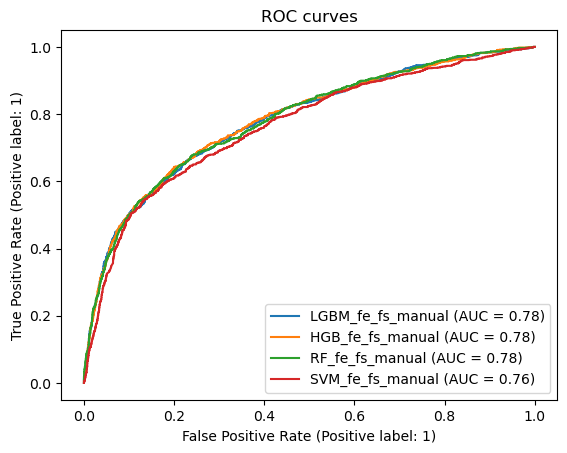

In [84]:
models = [
    ("LGBM_fe_fs_manual", models_trainer.models.get("LGBM_fe_fs_manual")),
    ("HGB_fe_fs_manual", models_trainer.models.get("HGB_fe_fs_manual")),
    ("RF_fe_fs_manual", models_trainer.models.get("RF_fe_fs_manual")),
    ("SVM_fe_fs_manual", models_trainer.models.get("SVM_fe_fs_manual"))      
]

X_train, y_train = models_trainer.X_train, models_trainer.y_train
X_val, y_val = models_trainer.X_val, models_trainer.y_val
X_test, y_test = models_trainer.X_test, models_trainer.y_test

fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_val, y_val, ax=ax, name=name
    )
_ = ax.set_title("ROC curves")

#ax.set_xlim(0, 0.3)
#ax.set_ylim(0.5, 0.8)
#_ = ax.set_title("ROC curve (zoomed in at top left)")

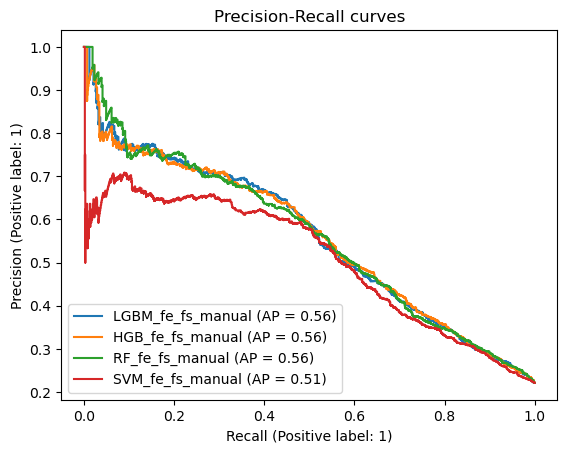

In [85]:
# Precision-recall curves:
fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = PrecisionRecallDisplay.from_estimator(
        pipeline, X_val, y_val, ax=ax, name=name
    )
_ = ax.set_title("Precision-Recall curves")

LGBM, HGB and RF have an extremely similar performance regarding their ROC curves and precision-recall curves. The main reasons for that might be due the fact the three are based on decision trees and share some underlying principles, such as being ensemble methods that use tree-based estimators to make predictions. They also have a comparable model complexity. 

From this moment onwards, SVM will be discarded, considering its inferior performance when compared to LGBM, HGB and RF.

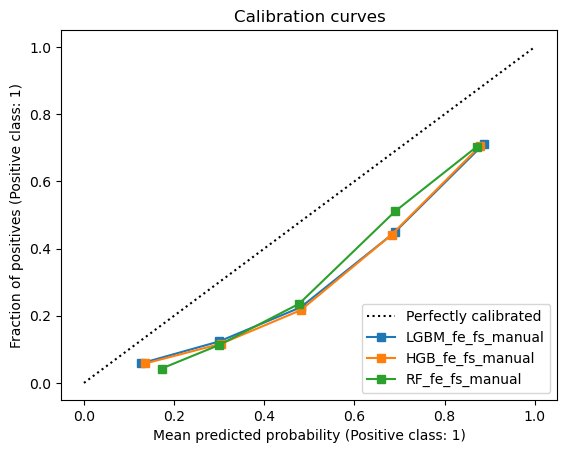

In [86]:
# Calibration curves:
models = models[0:3]

fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = CalibrationDisplay.from_estimator(
        pipeline, X_val, y_val, ax=ax, name=name
    )
_ = ax.set_title("Calibration curves")

All three calibration lines are below to the perfectly calibrated imaginary line, which means all models are showing signs of over-confidence. However, RF approximates slightly better the perfectly calibrated line for the positive class (it also haves a higher validation precision score than the other two models). 

Unfortunately, feature engineering and feature selection didn't bring the expected improvements in the results.

The models moving to the next phase where threshold moving will be performed are RF, LGBM and HGB. 

<br>

<div class="alert alert-block alert-info">
    <b>Current best f1-score:</b> 54%
</div>

### Modeling - Optimal Threshold Tuning

In [87]:
# Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

for m in models:
    print(f"\nSearching best threshold for {m[0]}")
    model = m[1]
    preds = model.predict_proba(X_val)
    # keep probabilities for the positive outcome only
    probs = preds[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.01)
    
    # evaluate each threshold
    scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
    
    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.2f' % (thresholds[ix], scores[ix]))


Searching best threshold for LGBM_fe_fs_manual
Threshold=0.620, F-Score=0.54

Searching best threshold for HGB_fe_fs_manual
Threshold=0.580, F-Score=0.55

Searching best threshold for RF_fe_fs_manual
Threshold=0.540, F-Score=0.55


Adjusting the probability threshold allowed to improve the validation f1-score in 1%. 

The models moving to the next phase to be tuned will are RF and HGB. 

<br>

<div class="alert alert-block alert-info">
    <b>Current best f1-score:</b> 55%
</div>

### Modeling - Hyperparameter Tuning

In [99]:
from sklearn.model_selection import RandomizedSearchCV

In [118]:
# HistGradientBoosting
params = {
    "max_iter": [100, 200],
    "max_depth": [None, 6, 8, 10, 12, 15, 20],
    "l2_regularization": [0, 0.001, 0.0001, 0.0001],
    "learning_rate": [0.1, 0.01, 0.001, 0.05, 0.025,],
    "early_stopping": [True],
    "n_iter_no_change": [10],
    "validation_fraction": [0.2],
    "class_weight": ["balanced"]
}

hgbc = HistGradientBoostingClassifier(
    categorical_features=['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'],
    random_state=seed
)

search = RandomizedSearchCV(
    hgbc,
    params,
    n_iter=30,
    cv=3,
    refit=True,
    verbose=True,
    random_state=seed,
    scoring="f1"
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(categorical_features=['pay_1',
                                                                                  'pay_2',
                                                                                  'pay_3',
                                                                                  'pay_4',
                                                                                  'pay_5',
                                                                                  'pay_6'],
                                                            random_state=1),
                   n_iter=30,
                   param_distributions={'class_weight': ['balanced'],
                                        'early_stopping': [True],
                                        'l2_regularization': [0, 0.001, 0.0001,
                                                              0.0001],
                                        'learning_rate': [0.1, 0.01, 0.001,
                                                          0.05, 0.025],
                                        'max_depth': [None, 6, 8, 10, 12, 15,
                                                      20],
                                        'max_iter': [100, 200],
                                        'n_iter_no_change': [10],
                                        'validation_fraction': [0.2]},
                   random_state=1, scoring='recall', verbose=True)

In [119]:
best_hgbc = search.best_estimator_

print(f'val recall = {search.best_score_}')
print(f'best_params = {search.best_params_}')

val recall = 0.5843659241687977
best_params = {'validation_fraction': 0.2, 'n_iter_no_change': 10, 'max_iter': 200, 'max_depth': 12, 'learning_rate': 0.001, 'l2_regularization': 0.001, 'early_stopping': True, 'class_weight': 'balanced'}


In [120]:
train_preds, val_preds = best_hgbc.predict(X_train), best_hgbc.predict(X_val)

print("Train dataset: \nf1_score -", round(f1_score(y_train, train_preds), 2), "\n", classification_report(y_train, train_preds))
print()
print("Val dataset: \nf1_score -", round(f1_score(y_val, val_preds), 2), "\n", classification_report(y_val, val_preds))

Train dataset: 
f1_score - 0.52 
               precision    recall  f1-score   support

           0       0.88      0.76      0.82     16354
           1       0.43      0.64      0.52      4646

    accuracy                           0.74     21000
   macro avg       0.66      0.70      0.67     21000
weighted avg       0.78      0.74      0.75     21000


Val dataset: 
f1_score - 0.52 
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      3505
           1       0.44      0.63      0.52       995

    accuracy                           0.74      4500
   macro avg       0.66      0.70      0.67      4500
weighted avg       0.78      0.74      0.76      4500



In [124]:
# Random Forest
params = {
    "criterion": ["log_loss", "gini", "entropy"],
    "n_estimators": [50, 75, 100, 125],
    "min_samples_split": [2, 5, 10, 20],
    "min_impurity_decrease": [0, 0.1, 0.01],
    "max_depth": [None, 6, 8, 10, 12],
    "max_features": [1.0],
    "max_samples": [0.8, 0.999],
    "ccp_alpha": [0.0, 0.005, 0.01, 0.015, 0.02],
    "class_weight": ["balanced"]
}

rfc = RandomForestClassifier(
    random_state=seed
)

search = RandomizedSearchCV(
    rfc,
    params,
    n_iter=30,
    cv=3,
    refit=True,
    verbose=True,
    random_state=seed,
    scoring="f1"
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_iter=30,
                   param_distributions={'ccp_alpha': [0.0, 0.005, 0.01, 0.015,
                                                      0.02],
                                        'class_weight': ['balanced'],
                                        'criterion': ['log_loss', 'gini',
                                                      'entropy'],
                                        'max_depth': [None, 6, 8, 10, 12],
                                        'max_features': [1.0],
                                        'max_samples': [0.8, 0.999],
                                        'min_impurity_decrease': [0, 0.1, 0.01],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 75, 100, 125]},
                   random_state=1, scoring='f1', verbose=True)

In [125]:
best_rfc = search.best_estimator_

print(f'val recall = {search.best_score_}')
print(f'best_params = {search.best_params_}')

val recall = 0.5317837959287951
best_params = {'n_estimators': 50, 'min_samples_split': 20, 'min_impurity_decrease': 0, 'max_samples': 0.999, 'max_features': 1.0, 'max_depth': 8, 'criterion': 'log_loss', 'class_weight': 'balanced', 'ccp_alpha': 0.0}


In [126]:
train_preds, val_preds = best_rfc.predict(X_train), best_rfc.predict(X_val)

print("Train dataset: \nf1_score -", round(f1_score(y_train, train_preds), 2), "\n", classification_report(y_train, train_preds))
print()
print("Val dataset: \nf1_score -", round(f1_score(y_val, val_preds), 2), "\n", classification_report(y_val, val_preds))

Train dataset: 
f1_score - 0.59 
               precision    recall  f1-score   support

           0       0.89      0.84      0.87     16354
           1       0.54      0.64      0.59      4646

    accuracy                           0.80     21000
   macro avg       0.72      0.74      0.73     21000
weighted avg       0.81      0.80      0.81     21000


Val dataset: 
f1_score - 0.54 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      3505
           1       0.51      0.58      0.54       995

    accuracy                           0.78      4500
   macro avg       0.69      0.71      0.70      4500
weighted avg       0.79      0.78      0.79      4500



ROC, precision-recall and calibration curves:

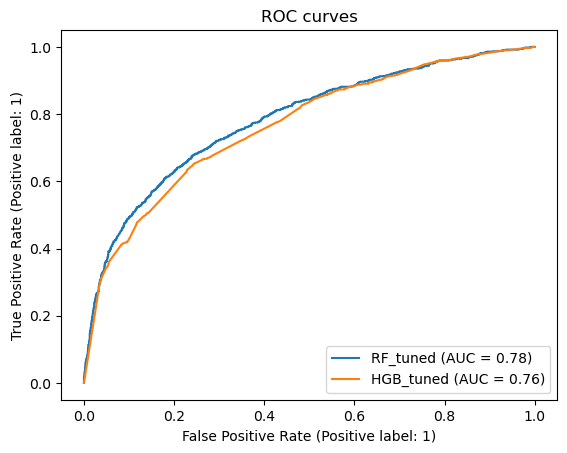

In [252]:
models = [
    ("RF_tuned", best_rfc),
    ("HGB_tuned", best_hgbc),
     
]

X_train, y_train = models_trainer.X_train, models_trainer.y_train
X_val, y_val = models_trainer.X_val, models_trainer.y_val
X_test, y_test = models_trainer.X_test, models_trainer.y_test

fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_val, y_val, ax=ax, name=name
    )
_ = ax.set_title("ROC curves")

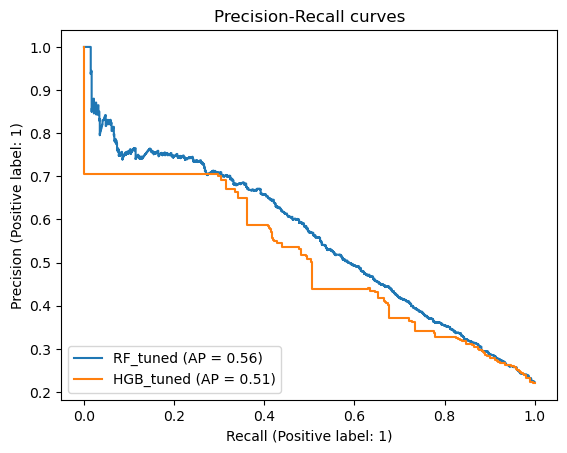

In [253]:
fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = PrecisionRecallDisplay.from_estimator(
        pipeline, X_val, y_val, ax=ax, name=name
    )
_ = ax.set_title("Precision-Recall curves")

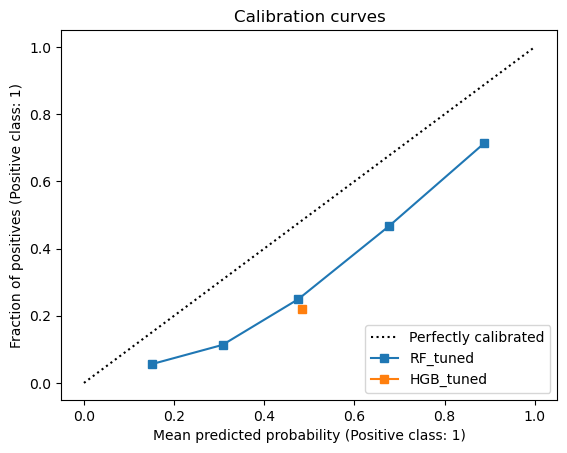

In [254]:
# Calibration curves:
fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = CalibrationDisplay.from_estimator(
        pipeline, X_val, y_val, ax=ax, name=name
    )
_ = ax.set_title("Calibration curves")

Optimal threshold tuning:

In [130]:
for m in models:
    print(f"\nSearching best threshold for {m[0]}")
    model = m[1]
    preds = model.predict_proba(X_val)
    # keep probabilities for the positive outcome only
    probs = preds[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.01)
    
    # evaluate each threshold
    scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
    
    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.2f' % (thresholds[ix], scores[ix]))


Searching best threshold for HGB_tuned
Threshold=0.500, F-Score=0.52

Searching best threshold for RF_tuned
Threshold=0.480, F-Score=0.54


### Modeling - Final Iterations and Calculation of Test Score

In [274]:
X_train, y_train = models_trainer.X_train, models_trainer.y_train
X_val, y_val = models_trainer.X_val, models_trainer.y_val
X_test, y_test = models_trainer.X_test, models_trainer.y_test

X_train.columns

Index(['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'bill_amt1', 'bill_amt2', 'bill_amt4', 'pay_amt1', 'pay_amt2',
       'pay_amt3', 'num_overpays', 'total_payment', 'payment_delay_amt1',
       'payment_delay_amt2'],
      dtype='object')

In [275]:
final_models_trainer = ModelTrainer(X_train, y_train, X_val, y_val, X_test, y_test, seed)

# Extend X_train with X_val
X_train_extended = pd.concat([X_train, X_val], axis=0, ignore_index=True)
# Concatenate y_train with y_val
y_train_extended = pd.concat([y_train, y_val], axis=0, ignore_index=True)

final_models_trainer.X_train = X_train_extended
final_models_trainer.y_train = y_train_extended

print(len(X_train_extended))

25500


In [276]:
final_rfc = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=20,
    max_depth=8,
    criterion="log_loss",
    class_weight="balanced",
    ccp_alpha=0.0,
    random_state=seed
)

final_hgbc = HistGradientBoostingClassifier(
    validation_fraction=0.2,
    n_iter_no_change=10,
    max_iter=200,
    max_depth=12,
    learning_rate=0.001,
    l2_regularization=0.001,
    early_stopping=True,
    class_weight="balanced",
    random_state=seed
)

In [277]:
final_models_trainer.train_classifier(classifier=final_rfc, classifier_name="RF_tuned")

final_models_trainer.evaluate_classifier(
    classifier_name="RF_tuned", 
    store_results=True, 
    print_classification_report=True,
    use_val_set=False,
    use_test_set=True,
)

	#### RF_TUNED RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     19859
           1       0.53      0.64      0.58      5641

    accuracy                           0.79     25500
   macro avg       0.71      0.74      0.72     25500
weighted avg       0.81      0.79      0.80     25500

Test scores:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3505
           1       0.49      0.59      0.54       995

    accuracy                           0.77      4500
   macro avg       0.68      0.71      0.69      4500
weighted avg       0.79      0.77      0.78      4500



{'test_f1_score': 0.54,
 'test_recall_score': 0.59,
 'test_precision_score': 0.49,
 'test_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.58,
 'train_recall_score': 0.64,
 'train_precision_score': 0.53,
 'train_balanced_accuracy_score': 0.74}

In [278]:
final_models_trainer.train_classifier(classifier=final_hgbc, classifier_name="HGB_tuned")

final_models_trainer.evaluate_classifier(
    classifier_name="HGB_tuned", 
    store_results=True, 
    print_classification_report=True,
    use_val_set=False,
    use_test_set=True,
)

	#### HGB_TUNED RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     19859
           1       0.50      0.61      0.55      5641

    accuracy                           0.78     25500
   macro avg       0.69      0.72      0.70     25500
weighted avg       0.80      0.78      0.79     25500

Test scores:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3505
           1       0.49      0.58      0.53       995

    accuracy                           0.77      4500
   macro avg       0.68      0.71      0.69      4500
weighted avg       0.79      0.77      0.78      4500



{'test_f1_score': 0.53,
 'test_recall_score': 0.58,
 'test_precision_score': 0.49,
 'test_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.55,
 'train_recall_score': 0.61,
 'train_precision_score': 0.5,
 'train_balanced_accuracy_score': 0.72}

In [279]:
results = final_models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="test_f1_score", ascending=False).T

,RF_tuned,HGB_tuned
test_f1_score,0.54,0.53
test_recall_score,0.59,0.58
test_precision_score,0.49,0.49
test_balanced_accuracy_score,0.71,0.71
train_f1_score,0.58,0.55
train_recall_score,0.64,0.61
train_precision_score,0.53,0.50
train_balanced_accuracy_score,0.74,0.72


In [280]:
undersampling_perc = 0.33
zero_indexes = np.where(y_train_extended == 0)[0]

# Randomly select a subset of indexes based on the undersampling percentage
undersample_indexes = np.random.choice(zero_indexes, size=int(len(zero_indexes) * undersampling_perc), replace=False)

# Remove the undersampled indexes from X_train_extended and y_train_extended
X_train_undersampled = X_train_extended.drop(undersample_indexes)
y_train_undersampled = y_train_extended.drop(undersample_indexes)

print(y_train_undersampled.sum() / len(y_train_undersampled))
print(len(y_train_undersampled))

final_models_trainer.X_train = X_train_undersampled
final_models_trainer.y_train = y_train_undersampled

0.29772523354620783
18947


In [281]:
final_rfc = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=20,
    max_depth=10,
    criterion="log_loss",
    class_weight="balanced",
    ccp_alpha=0.0,
    random_state=seed
)

final_hgbc = HistGradientBoostingClassifier(
    validation_fraction=0.2,
    n_iter_no_change=10,
    max_iter=200,
    max_depth=12,
    learning_rate=0.001,
    l2_regularization=0.001,
    early_stopping=True,
    class_weight="balanced",
    random_state=seed
)

In [282]:
final_models_trainer.train_classifier(classifier=final_rfc, classifier_name="RF_tuned_sampled")

final_models_trainer.evaluate_classifier(
    classifier_name="RF_tuned_sampled", 
    store_results=True, 
    print_classification_report=True,
    use_val_set=False,
    use_test_set=True,
)

	#### RF_TUNED_SAMPLED RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     13306
           1       0.65      0.66      0.65      5641

    accuracy                           0.79     18947
   macro avg       0.75      0.75      0.75     18947
weighted avg       0.79      0.79      0.79     18947

Test scores:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3505
           1       0.49      0.59      0.54       995

    accuracy                           0.77      4500
   macro avg       0.68      0.71      0.69      4500
weighted avg       0.79      0.77      0.78      4500



{'test_f1_score': 0.54,
 'test_recall_score': 0.59,
 'test_precision_score': 0.49,
 'test_balanced_accuracy_score': 0.71,
 'train_f1_score': 0.65,
 'train_recall_score': 0.66,
 'train_precision_score': 0.65,
 'train_balanced_accuracy_score': 0.75}

In [283]:
final_models_trainer.train_classifier(classifier=final_hgbc, classifier_name="HGB_tuned_sampled")

final_models_trainer.evaluate_classifier(
    classifier_name="HGB_tuned_sampled", 
    store_results=True, 
    print_classification_report=True,
    use_val_set=False,
    use_test_set=True,
)

	#### HGB_TUNED_SAMPLED RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82     13306
           1       0.58      0.63      0.61      5641

    accuracy                           0.76     18947
   macro avg       0.71      0.72      0.71     18947
weighted avg       0.76      0.76      0.76     18947

Test scores:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      3505
           1       0.46      0.60      0.52       995

    accuracy                           0.76      4500
   macro avg       0.67      0.70      0.68      4500
weighted avg       0.78      0.76      0.77      4500



{'test_f1_score': 0.52,
 'test_recall_score': 0.6,
 'test_precision_score': 0.46,
 'test_balanced_accuracy_score': 0.7,
 'train_f1_score': 0.61,
 'train_recall_score': 0.63,
 'train_precision_score': 0.58,
 'train_balanced_accuracy_score': 0.72}

In [284]:
results = final_models_trainer.get_results_dict()
df_results = pd.DataFrame.from_dict(results, orient="index")
df_results.sort_values(by="test_f1_score", ascending=False).T

,RF_tuned,RF_tuned_sampled,HGB_tuned,HGB_tuned_sampled
test_f1_score,0.54,0.54,0.53,0.52
test_recall_score,0.59,0.59,0.58,0.60
test_precision_score,0.49,0.49,0.49,0.46
test_balanced_accuracy_score,0.71,0.71,0.71,0.70
train_f1_score,0.58,0.65,0.55,0.61
train_recall_score,0.64,0.66,0.61,0.63
train_precision_score,0.53,0.65,0.50,0.58
train_balanced_accuracy_score,0.74,0.75,0.72,0.72


ROC, precision-recall and calibration curves:

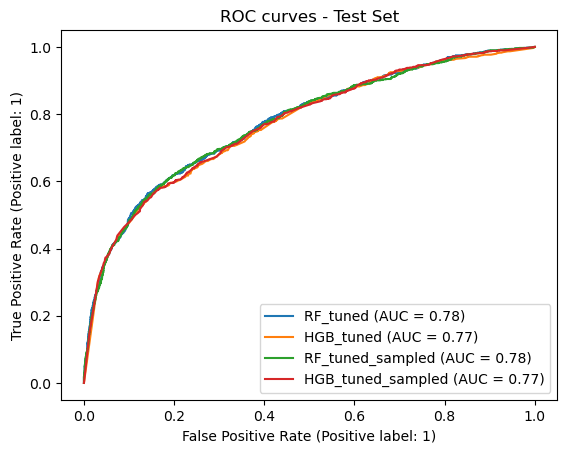

In [285]:
models = [
    ("RF_tuned", final_models_trainer.models["RF_tuned"]),
    ("HGB_tuned", final_models_trainer.models["HGB_tuned"]),
    ("RF_tuned_sampled", final_models_trainer.models["RF_tuned_sampled"]),
    ("HGB_tuned_sampled", final_models_trainer.models["HGB_tuned_sampled"]),   
]

X_train, y_train = final_models_trainer.X_train, final_models_trainer.y_train
X_test, y_test = final_models_trainer.X_test, final_models_trainer.y_test

fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("ROC curves - Test Set")

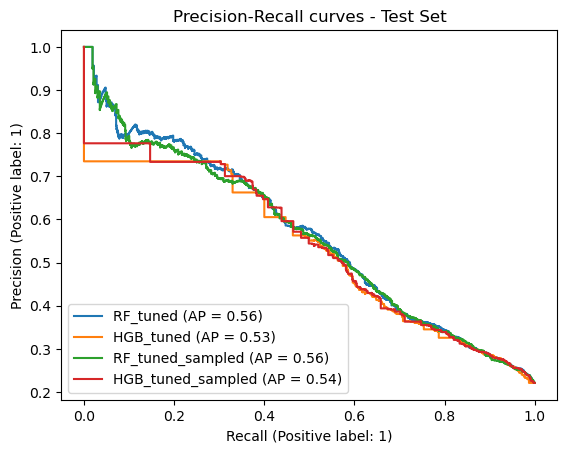

In [286]:
fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = PrecisionRecallDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("Precision-Recall curves - Test Set")

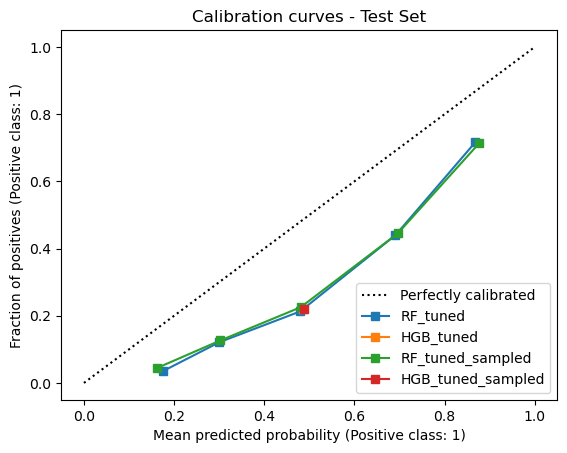

In [287]:
# Calibration curves:
fig, ax = plt.subplots()
model_displays = {}
for name, pipeline in models:
    model_displays[name] = CalibrationDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("Calibration curves - Test Set")

Optimal threshold tuning:

In [288]:
for m in models:
    print(f"\nSearching best threshold for {m[0]}")
    model = m[1]
    preds = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = preds[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.01)
    
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
    
    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.2f' % (thresholds[ix], scores[ix]))


Searching best threshold for RF_tuned
Threshold=0.530, F-Score=0.54

Searching best threshold for HGB_tuned
Threshold=0.500, F-Score=0.53

Searching best threshold for RF_tuned_sampled
Threshold=0.530, F-Score=0.54

Searching best threshold for HGB_tuned_sampled
Threshold=0.520, F-Score=0.53


### Results interpretability

In [289]:
X_train, y_train = final_models_trainer.X_train, models_trainer.y_train
X_test, y_test = final_models_trainer.X_test, models_trainer.y_test

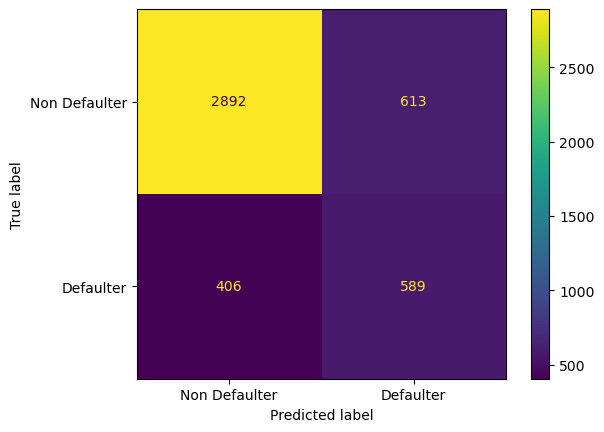

In [290]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
best_model = final_models_trainer.models.get("RF_tuned_sampled")

cm = confusion_matrix(y_test.values, best_model.predict(X_test))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non Defaulter', 'Defaulter']
)

disp.plot()

plt.show()

In [291]:
tn, fp, fn, tp = cm.ravel()

print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

print(f"Number of labels predicted as 1 vs 0: {tp + fp} vs. {tn + fn}")

True negatives: 2892
False positives: 613
False negatives: 406
True positives: 589
Number of labels predicted as 1 vs 0: 1202 vs. 3298


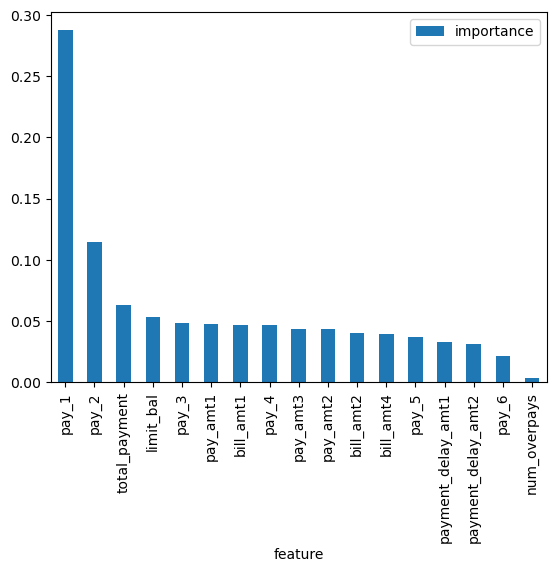

In [292]:
# Feature importance:
feat_imp = pd.DataFrame(
    zip(best_model.feature_names_in_, best_model.feature_importances_),
    columns=["feature", "importance"]
).sort_values(by="importance", ascending=False)

feat_imp.plot.bar(x='feature', y='importance', rot=90)
plt.show()

In [297]:
import sklearn

sklearn.__version__

'1.3.0'

In [296]:
# SHAP values:
# clf = SVC(random_state=seed)
# clf.fit(X_train, y_train)
import shap

#shap.initjs()

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

explainer = shap.KernelExplainer(best_model.predict_proba, X_train)
# explainer = shap.TreeExplainer(best_model)
shap_values = explainer(test_data)

exp = shap.Explanation(
    shap_values.values[:,:,1], 
    shap_values.base_values[:,1], 
    data=test_data.values, 
    feature_names=test_data.columns
)

shap.summary_plot(
    shap_values=exp,
    features=test_data
)

ImportError: cannot import name '_eigh' from 'sklearn.utils.fixes' (C:\Users\mafal\anaconda3\lib\site-packages\sklearn\utils\fixes.py)

Unfortunately, due to time constraints, there was no time to adapt the SHAP values to have the interpretation of the SVM model. As an alternative, shap values were calculated for a simple decision tree model. 

### Conclusions and next steps

The results of our analysis showed that the SVM model achieved the best performance with a recall score of 74%. 


The most relevant features to predict the probability of a client defaulting are past payment statuses (in particular the most recent months), paid amount to bill ratios, payment change rates, payment delays, credit limits, the total amount paid by the client during the last 6 months and information regarding client's age and marital status.


Further research is needed to refine the model and improve its performance. 



**Next Steps and future work might include:**
- EDA:
    - Invest more in multivariate analysis
    - Deal with repetitive code
    - Improve feature engineering
    - Treat outliers (IQR)
- Dataset imbalance:
    - Try to get more data from the source
    - Synthetic data
- Feature selection:
    - Explore other methods:
    - Recursive Feature Elimination
    - Correlation-based feature selection 
    - Using the feature importance of some tree-based classifiers to rank the features
    - "Manual selection"
    - Genetic algorithms
- Models:
    - Hyperparameter tuning
    - Regularization techniques (if needed)
    - Deep learning neural networks
- Interpretability:
    - Adapt SHAP values to SVM
- Code:
    - Finish documentation and write a proper readme file, including instructions on how to run the project
    - Add proper logging
    - Refactor DataProcessor and ModelTrainer classes
    - Create a report manager
    - Integration with MLFlow (or similar tool) to facilitate experiment tracking
    - Production code:
        - OOP
        - Unit, integration and acceptance tests
        - Apply lint packages (e.g., autopep8, pylint)
        - Dependencies management (e.g., Poetry)